# Two approaches in dealing with uncertainty
A Bayesian and Frequentist approach to prediction uncertainty. In both cases, I want to define both aleatoric and epistemic uncertainty.

Imports

In [411]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pymc3 as pm

from functools import partial

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from scipy import stats, interpolate

## Generating a dataset

In [2]:
np.random.seed(42)

w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=300, n_tst=150):
    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)
    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    x = x[..., np.newaxis]
    x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
    x_tst = x_tst[..., np.newaxis]
    return y, x, x_tst

y, x, x_tst = load_dataset()

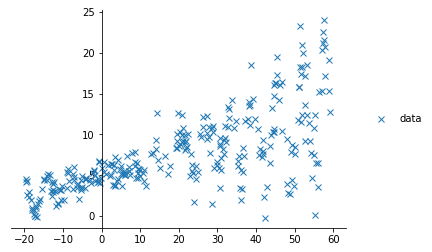

In [3]:
ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.plot(x, y, 'x', label='data')
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

## Scaling the data

In [4]:
ssx = MinMaxScaler()#StandardScaler()
x = ssx.fit_transform(x)

ssy = MinMaxScaler()#StandardScaler()
y = ssy.fit_transform(y.reshape(-1, 1))

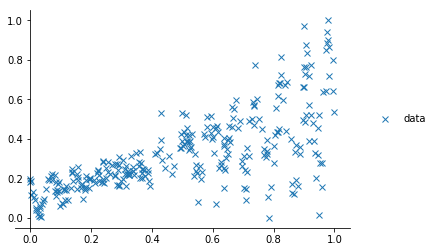

In [5]:
ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.plot(x, y, 'x', label='data')
plt.legend(loc='center left', fancybox=True, framealpha=0., bbox_to_anchor=(1.05, 0.5))

### Customized data generator
but somehow doesn't work and makes model very slow...

In [6]:
# np.random.seed(1)

# w0 = .2
# b0 = .25
# x_range = [-.5, 1]

# def load_dataset(n=150, n_tst=150):
#     def s(x):
#         g = (x - x_range[0]) / (x_range[1] - x_range[0]) / 2.5
#         return .05 + g**2
    
#     x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
#     eps = np.random.randn(n) * s(x) 
#     y = (w0 * x * (1. + np.sin(x)) + b0) + eps
#     x = x[..., np.newaxis]
#     x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
#     x_tst = x_tst[..., np.newaxis]
#     return y, x, x_tst

# y, x, x_tst = load_dataset()

## The Bayesian approach

**Priors**:

$\alpha \sim N(0, 10)$

$\beta \sim N(0, 10)$

Linear Regression: $\mu = \alpha + \beta x$

**Likelihood**: 

$y \sim N(\mu, \sigma)$

**(Extra) Increasing variance**:

$\sigma_{scale} \sim N(0, 10)$

$\sigma_{bias} \sim N^+(10)$

$\sigma = \sigma_{bias} + \sigma_{scale} * x$

As you can see on the plot, the variance increases when x increases. Therefore I model the variance as a softplus method.

## Modelling in PyMC3
Modelling a linear regression with increasing variance. 

In [7]:
with pm.Model() as m:
    alpha = pm.Normal('alpha', 0, 10)
    beta = pm.Normal('beta', 0, 10)
    mu = pm.Deterministic('mu', alpha + beta * x)
    sd_scale = pm.Normal('sd_scale', mu=0, sd=10)
    sd_bias = pm.HalfNormal('sd_bias', sd=10) + 1e-5
    sd = pm.Deterministic('sigma', sd_bias + mu * sd_scale)
    obs = pm.Normal('obs', mu, sd=sd, observed=y)
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_bias, sd_scale, beta, alpha]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:04<00:00, 2022.72draws/s]
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6054235431664662, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9145500120516135, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6646977526208057, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [130]:
with m:
    posterior = pm.sample_posterior_predictive(trace)
    
posterior['obs'].shape

100%|██████████| 8000/8000 [00:04<00:00, 1624.77it/s]


(8000, 300, 1)

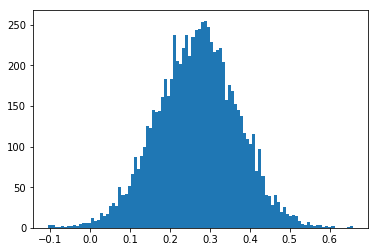

In [131]:
plt.hist(posterior['obs'][:, 0, 0], bins=100);

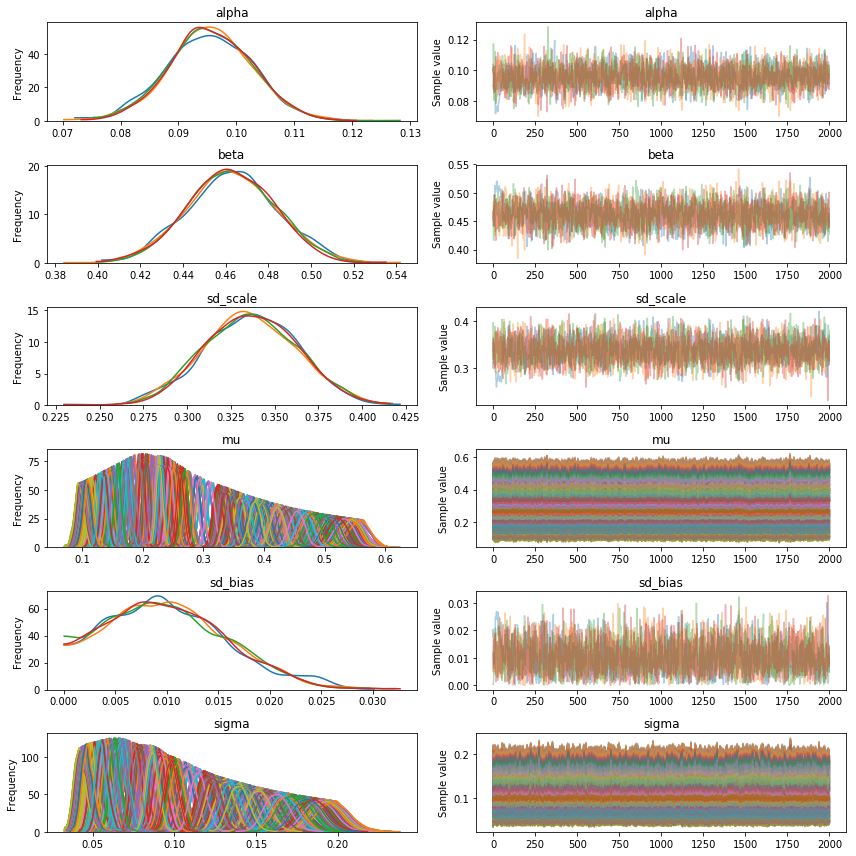

In [10]:
pm.traceplot(trace);

## Postprocessing
Sort and calculate credible intervals (2$ * \sigma$) for visualization

In [209]:
sorted_mask = np.argsort(x, axis=0).flatten()
x_ = x[sorted_mask]
mu = (trace['alpha'] + trace['beta'] * x_)
sigma = np.transpose(np.squeeze(trace['sigma'], axis=-1))[sorted_mask, ...]
quantile_preds = np.array([
    mu - 2 * sigma, 
    mu - 1 * sigma,
    mu, 
    mu + 1 * sigma, 
    mu + 2 * sigma
])
preds_b = np.swapaxes(quantile_preds, 0, 1)

In [16]:
sigma.shape, mu.shape

((300, 8000), (300, 8000))

## Plotting median and credible interval (2$*\sigma$)

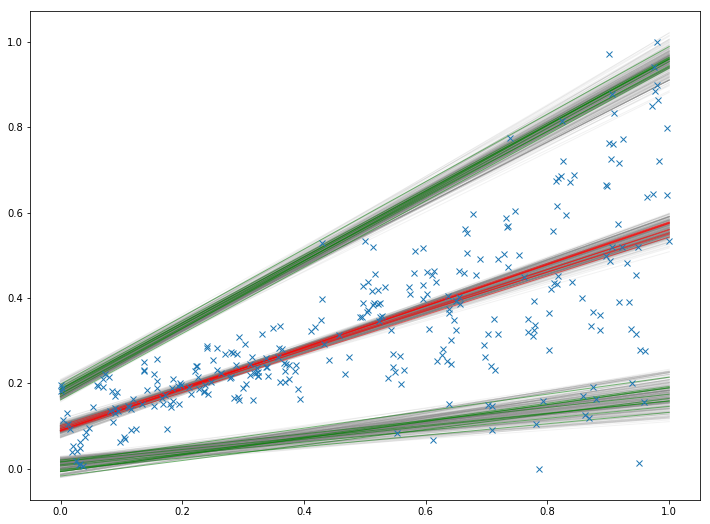

In [18]:
plt.figure(figsize=(12, 9))
n = 300
n_c = 10

plt.plot(x_, mu[..., :n], alpha=.1, lw=1, c='grey')
plt.plot(x_, quantile_preds[0, :, :n], alpha=.1, lw=1, c='grey')
plt.plot(x_, quantile_preds[-1, :, :n], alpha=.1, lw=1, c='grey')
plt.plot(x_, mu[..., n:n+n_c], alpha=.5, lw=1, c='red')
plt.plot(x_, quantile_preds[0][:, n:n+n_c], alpha=.5, lw=1, c='green')
plt.plot(x_, quantile_preds[-1][:, n:n+n_c], alpha=.5, lw=1, c='green')

plt.plot(x, y, 'x');

## Quantile regression neural network, using MCDropout (in PyTorch)

In [188]:
def QuantileLoss(preds, target, quantiles):
    assert not target.requires_grad
    assert preds.size(0) == target.size(0), f'preds.size:{preds.shape} target.size:{quantiles.shape}'
    assert preds.size(1) == quantiles.shape[0], f'preds.size:{preds.shape} quantiles.shape:{quantiles.shape}'

    def _tilted_loss(q, e):
        return torch.max((q-1) * e, q * e).unsqueeze(1)

    err = target - preds
    losses = [_tilted_loss(q, err[:, i])  # calculate per quantile
              for i, q in enumerate(quantiles)]

    loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
    return loss

class Dropout_on_dim(torch.nn.modules.dropout._DropoutNd):
    """ Dropout that masks the (hidden) features equally over a batch """
    def __init__(self, p, dim=1, **kwargs):
        super().__init__(p, **kwargs)
        self.dropout_dim = dim
        self.multiplier_ = 1.0 / (1.0-self.p)
        
    def forward(self, X):
        mask = torch.autograd.Variable(
            torch.bernoulli(
                X.new(X.size(self.dropout_dim)).fill_(1-self.p)
            )
        )
        return X * mask * self.multiplier_
    
class DeepQuantileRegression(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.hidden_size = params['hidden_size']
        self.quantiles = params['quantiles']
        self.model = nn.Sequential(
            nn.Linear(params['input_size'], params['hidden_size']),
#             nn.ReLU(),  # when you want to model non-linearities
            Dropout_on_dim(params['dropout_p'], dim=params['dropout_dim']),
            nn.Linear(params['hidden_size'], params['hidden_size']),
#             nn.ReLU(),  # when you want to model non-linearities
            Dropout_on_dim(params['dropout_p'], dim=params['dropout_dim']),
            nn.Linear(params['hidden_size'], len(params['quantiles']))
        )
    
    def forward(self, X):
        return self.model(X)
    
    
def get_quantile_pred(q, used_quantiles, preds):
#     assert preds.shape[0] == used_quantiles.shape[0]
    interp_cdf = interpolate.interp1d(used_quantiles, preds, fill_value='extrapolate')
    return interp_cdf(q)

    
def get_model(params):
    model = DeepQuantileRegression(params)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    return model, optimizer

## Setting up
- model, model config
- data loader/generator

In [139]:
def create_quantiles(n, min_q=0.01, max_q=0.99):
    """ Create array of quantiles, given desired number of quantiles. """
    n -= 2  # because we add the lowest and highest quantiles manually
    n_equally_spaced = np.linspace(1 / (n + 1), 1 - 1 / (n + 1), n)
    quantiles = np.concatenate([np.array([min_q]), 
                                n_equally_spaced, 
                                np.array([max_q])])
    return quantiles

create_quantiles(9, min_q=0.025, max_q=0.975), QUANTILES

(array([0.025, 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 0.975]),
 array([0.01, 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 0.99]))

In [330]:
# QUANTILES = np.array([0.025, 0.16, 0.5, 0.84, 0.975])  # -2std, -1std, median, 1std, 2std
QUANTILES = create_quantiles(21, min_q=0.01, max_q=0.99)
params = {
    'input_size': 1,
    'hidden_size': 256,
    'dropout_p': 0.1,
    'dropout_dim': 1,
    'quantiles': QUANTILES,
    'batch_size': 16,
    'epochs': 2001,
    'lr': 1e-5,
    'weight_decay': 1e-5,
}
model, optim = get_model(params)
criterion = partial(QuantileLoss, quantiles=QUANTILES)

train_ds = TensorDataset(torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
train_dl = DataLoader(train_ds, params['batch_size'], shuffle=True)

## Training the model

In [349]:
for epoch in range(params['epochs']):
    for x_batch, y_batch in train_dl:
        model.train()
        preds = model(x_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optim.step()
        optim.zero_grad()
        
        model.eval()
        with torch.no_grad():
            x_val, y_val = train_dl.dataset.tensors
            val_loss = criterion(model(x_val), y_val)  # for now same as train set
    
    if epoch % 50 == 0:
        print(f"Epoch: {epoch} \t Loss: {val_loss}")

Epoch: 0 	 Loss: 0.7514734864234924
Epoch: 50 	 Loss: 0.7247959971427917
Epoch: 100 	 Loss: 0.7231384515762329
Epoch: 150 	 Loss: 0.7565207481384277
Epoch: 200 	 Loss: 0.7175246477127075
Epoch: 250 	 Loss: 0.7478687167167664
Epoch: 300 	 Loss: 0.7176663875579834
Epoch: 350 	 Loss: 0.7312898635864258
Epoch: 400 	 Loss: 0.7296720147132874
Epoch: 450 	 Loss: 0.7311752438545227
Epoch: 500 	 Loss: 0.7247031927108765


## Check if custom dropout layer works as intended

In [350]:
with torch.no_grad():
    model.train()
    x_val_test = torch.zeros(x_val.shape)
    preds_test = np.array([model(x_val_test).numpy() for _ in range(8000)])
    
assert np.array_equal(preds_test[:, 0], preds_test[:, 1]) == True  # every row in batch is masked equally
assert np.array_equal(preds_test[0, :], preds_test[1, :]) == False  # every column (hidden feature) is masked randomly per batch

## Predict

In [351]:
with torch.no_grad():
    model.train()
    qr_preds = np.array([model(x_val).numpy() for _ in range(8000)])

## Some postprocessing

In [352]:
preds_ = np.swapaxes(np.swapaxes(qr_preds, 0, -1), 0, 1)
qr_preds.shape, preds_.shape

((8000, 300, 21), (300, 21, 8000))

In [353]:
sorted_index = x_val.argsort(axis=0).flatten()
x_, y_hat = x_val[sorted_index, ...].numpy(), preds_[sorted_index, ...]
x_.shape, y_hat.shape

((300, 1), (300, 21, 8000))

## Plotting median and credible interval (2$*\sigma$)

In [354]:
q_975 = np.array([
    get_quantile_pred(q=.975, used_quantiles=QUANTILES, preds=y_hat[:, :, i]) 
    for i in range(y_hat.shape[-1])
]).T

q_025 = np.array([
    get_quantile_pred(q=.025, used_quantiles=QUANTILES, preds=y_hat[:, :, i]) 
    for i in range(y_hat.shape[-1])
]).T

median_i = int(QUANTILES.shape[0]/2)
q_50 = y_hat[:, median_i, :]

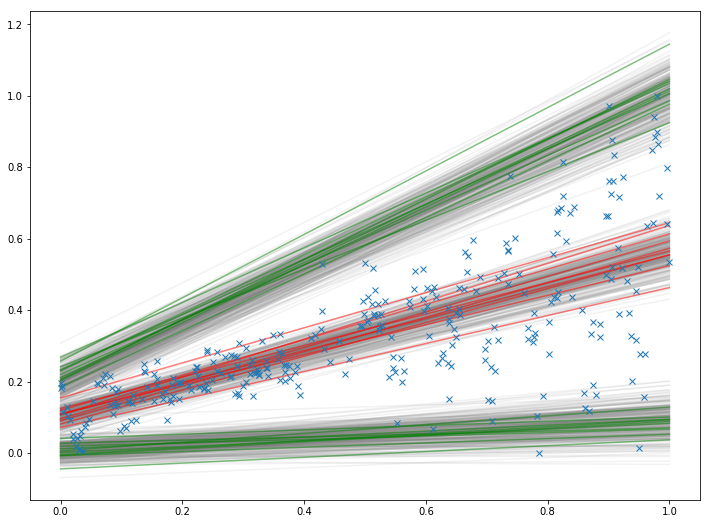

In [355]:
plt.figure(figsize=(12, 9))
n = 300
n_c = 10

plt.plot(x_, q_025[:, :n], c='grey', alpha=.1)
plt.plot(x_, q_50[:, :n], c='grey', alpha=.1)
plt.plot(x_, q_975[:, :n], c='grey', alpha=.1)
plt.plot(x_, q_025[:, n:n+n_c], c='green', alpha=.5)
plt.plot(x_, q_50[:, n:n+n_c], c='red', alpha=.5)
plt.plot(x_, q_975[:, n:n+n_c], c='green', alpha=.5)

plt.plot(x, y, 'x')
plt.show();

## Comparing the outcome of the two methods

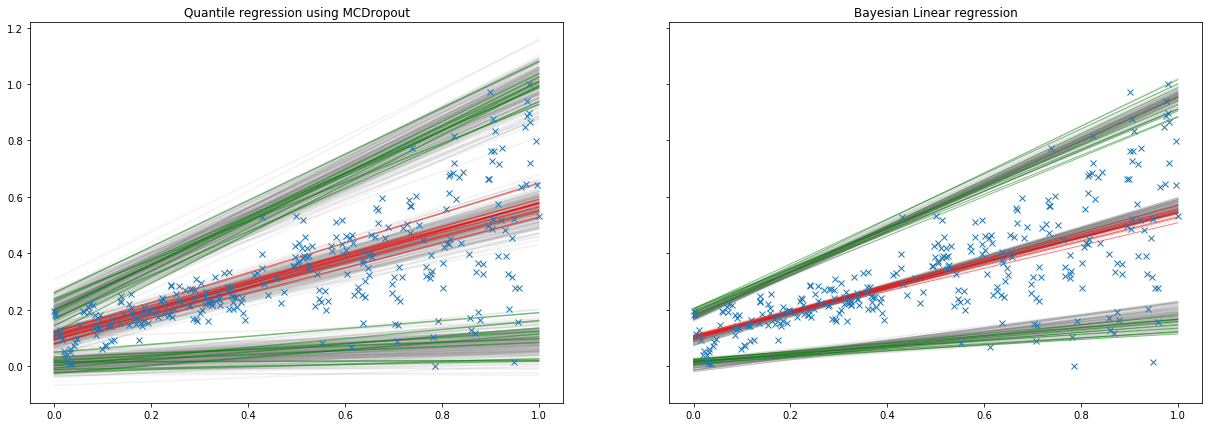

In [356]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(21,7))
n = 200
n_c = 10

axes[0].plot(x_, q_025[:, :n], c='grey', alpha=.1)
axes[0].plot(x_, q_50[:, :n], c='grey', alpha=.1)
axes[0].plot(x_, q_975[:, :n], c='grey', alpha=.1)
axes[0].plot(x_, q_025[:, n:n+n_c], c='green', alpha=.5)
axes[0].plot(x_, q_50[:, n:n+n_c], c='red', alpha=.5)
axes[0].plot(x_, q_975[:, n:n+n_c], c='green', alpha=.5)
axes[0].plot(x, y, 'x')
axes[0].set_title('Quantile regression using MCDropout')

axes[1].plot(x_, mu[..., :n], alpha=.1, lw=1, c='grey')
axes[1].plot(x_, quantile_preds[0, :, :n], alpha=.1, lw=1, c='grey')
axes[1].plot(x_, quantile_preds[-1, :, :n], alpha=.1, lw=1, c='grey')
axes[1].plot(x_, mu[..., n:n+n_c], alpha=.5, lw=1, c='red')
axes[1].plot(x_, quantile_preds[0][:, n:n+n_c], alpha=.5, lw=1, c='green')
axes[1].plot(x_, quantile_preds[-1][:, n:n+n_c], alpha=.5, lw=1, c='green')
axes[1].plot(x, y, 'x')
axes[1].set_title('Bayesian Linear regression');

## Averaging
When taking the mean of the samples, the result is quite close...

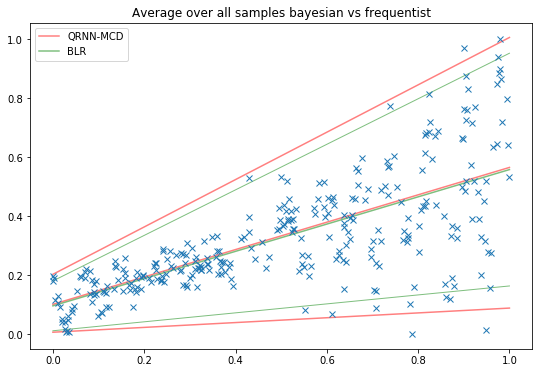

In [357]:
fig = plt.figure(figsize=(9,6))

plt.plot(x_, np.mean(q_025[:, :], axis=-1), c='red', alpha=.5)
plt.plot(x_, np.mean(q_50[:, :], axis=-1), c='red', alpha=.5, label="QRNN-MCD")
plt.plot(x_, np.mean(q_975[:, :], axis=-1), c='red', alpha=.5)

plt.plot(x_, np.mean(mu, axis=-1), alpha=.5, c='green', label="BLR")
plt.plot(x_, np.mean(quantile_preds[0], axis=-1), alpha=.5, lw=1, c='green')
plt.plot(x_, np.mean(quantile_preds[-1], axis=-1), alpha=.5, lw=1, c='green')

plt.plot(x, y, 'x')
plt.title('Average over all samples bayesian vs frequentist')
plt.legend();

## Looking at single predictions

In [358]:
def spread(preds) -> np.array:
    """ Calculates the spread of the predictions per quantile """
    spreads = np.zeros(preds.shape[0])
    avg_factor = 2 * preds.shape[1] * (preds.shape[1] - 1)
    for i in range(preds.shape[0]):
        spreads[i] = (
            np.sum(np.abs(np.subtract.outer(preds[i], preds[i]))) / avg_factor
        )
    return spreads


def distance(y_true, preds) -> np.array:
    """ Calculates the avg distance of the quantile predictions compared to
    the actual """
    return np.mean(np.abs(preds - y_true.reshape(-1, 1)), axis=1)


def rps(y_true: np.array, preds: np.array) -> np.float64:
    """ Function that calculates the RPS by calculating and substracting the
    distance of the distribution compared to the actual value and the spread of
    the distribution.

    Implementation is based on a previous implementation @KLM, in order to
    compare scores of 'old' models and new developped ones. For more info,
    please check: https://bitbucket.devnet.klm.com/projects/OPSM/repos/delay_predictor/browse/delayprediction/metrics.py#106

    Parameters
    ----------
    y_true
        Array containing the actual delays, size = (batch_size x 1)
    preds
        Array containing the predictions of the 21 quantiles,
        size = (batch_size x 21)

    Returns
    -------
    :
        RPS score
    """
    rps_scores = distance(y_true, preds) - spread(preds)
    return np.mean(rps_scores)

## Aiming for the true posterior

/home/yuri/.local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/yuri/.local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/yuri/.local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/yuri/.local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: Future

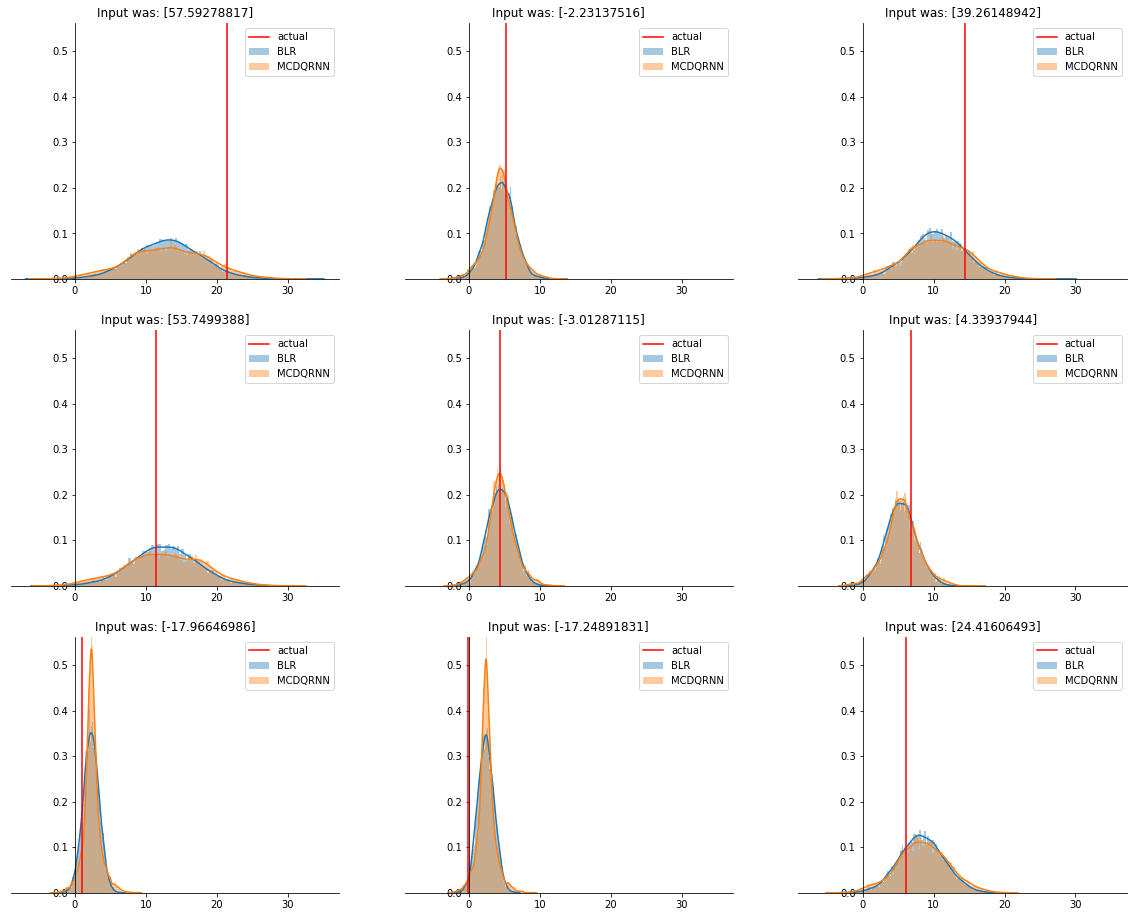

In [436]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(20,16))
for i, ax in enumerate(axes.flat):
    i = np.random.randint(0, 300)
    
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    blr_posterior = ssy.inverse_transform(posterior['obs'][:, i, 0].reshape(-1,1))
    sns.distplot(blr_posterior, bins=100, ax=ax, label='BLR')
    mcd_qrnn_posterior = ssy.inverse_transform(
        np.array([
            get_quantile_pred(q=stats.uniform.rvs(), 
                              used_quantiles=QUANTILES, 
                              preds=qr_preds[s, i, :])
            for s in range(qr_preds.shape[0])
        ]).reshape(-1,1)
    )
    sns.distplot(mcd_qrnn_posterior, bins=100, ax=ax, label='MCDQRNN');
    ax.axvline(ssy.inverse_transform(y)[i], c='r', label='actual')
    ax.set_title(f"Input was: {ssx.inverse_transform(x)[i]}")
    ax.legend()
plt.show()

## Comparing RPS scores

In [417]:
mcd_qrnn_posterior = np.array([get_quantile_pred(q=stats.uniform.rvs(), used_quantiles=QUANTILES, preds=qr_preds[s, :, :]) 
                               for s in range(qr_preds.shape[0])])
mcd_qrnn_21qs = np.quantile(mcd_qrnn_posterior, QUANTILES, axis=0)
blr_21qs = np.quantile(posterior['obs'][:, :, 0], QUANTILES, axis=0)

In [431]:
print("Comparing RPS (lower is better)")
print("="*31)
print(f"RPS-QRMCDNN:{rps(ssy.inverse_transform(y), ssy.inverse_transform(mcd_qrnn_21qs.T)):.5f}")
print(f"RPS-BLR    :{rps(ssy.inverse_transform(y), ssy.inverse_transform(blr_21qs.T)):.5f}")

Comparing RPS (lower is better)
RPS-QRMCDNN:1.60212
RPS-BLR    :1.61315


In [429]:
print("Comparing MAE of the mean of the posterior (lower is better)")
print("="*60)
mae_b = mean_absolute_error(
    ssy.inverse_transform(y), 
    ssy.inverse_transform(np.mean(posterior['obs'][:, :, 0], axis=0).reshape(-1,1))
)
mae_qr = mean_absolute_error(
    ssy.inverse_transform(y), 
    ssy.inverse_transform(np.mean(mcd_qrnn_posterior, axis=0).reshape(-1,1))
)
print(f"RPS-QRMCDNN: {mae_qr}")
print(f"RPS-BLR    : {mae_b}")

Comparing MAE of the mean of the posterior (lower is better)
RPS-QRMCDNN: 2.3854238907555136
RPS-BLR    : 2.3848693093508846
